## Feature Engineering Deep Dive チュートリアル

- [1. データの読み込みと確認](#readData)
    - データのロードと内容確認
    - 型変換
- [2. ベースラインモデルの作成](#baseline)
    - AutoML
    - モデルパフォーマンスと変数重要度の確認
- [3. Feature Engineeringとそれを利用したモデルの作成](#FE)
    - Feature Engineeringの実施
    - XXX

In [81]:
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
from h2o.automl import H2OAutoML

In [2]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxd4lvkra
  JVM stdout: /tmp/tmpxd4lvkra/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmpxd4lvkra/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_ec2_user_ydevjs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.399 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


***

<a id='readData'></a>
### 1. データの読み込みと確認

In [3]:
#> データのロード
loans = h2o.import_file("https://sample-data-open.s3-ap-northeast-1.amazonaws.com/h2o_sample_loan/loan.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loans.head(5)

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
5000,36 months,10.65,10,RENT,24000,credit_card,AZ,27.65,0,83.7,9,0,26,verified
2500,60 months,15.27,0,RENT,30000,car,GA,1,0,9.4,4,1,12,verified
2400,36 months,15.96,10,RENT,12252,small_business,IL,8.72,0,98.5,10,0,10,not verified
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5000,36 months,7.9,3,RENT,36000,wedding,AZ,11.2,0,28.3,12,0,7,verified


In [5]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,int,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,0.0,0.0,
mean,13074.169141456336,,13.715904065566168,5.684352932995333,,71915.67051974915,,,15.881530121290089,0.2273570060625282,54.07917280242262,24.57973383427463,0.1830388994249544,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,1.0,65.0,
sigma,7993.556188734652,,4.3919398705457935,3.610663731100237,,59070.91565491827,,,7.587668224192549,0.694167922928418,25.285366766770515,11.685190365910659,0.3866995896078875,6.947732922546697,
zeros,0,,0,14248,,0,,,270,139459,1562,0,133971,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0.0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1.0,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0.0,10.0,not verified


#### データに関して

[LendingClub](https://www.lendingclub.com/info/statistics.action)データに対しデータクレンジングと簡素化を実施したもの

|Id  | Column Name | Description | 説明 |
|:---|:----------------------|:-------------------|:-------------------|
|1   | loan_amnt             | Requested loan amount (US dollars)       | 申し込まれたローンの額(USD) |
|2   | term                  | Loan term length (months)       | 申し込まれたローン期間(月) |
|3   | int_rate              | Recommended interest rate       | 貸出金利 |
|4   | emp_length            | Employment length (years)       | 継続雇用期間(年) |
|5   | home_ownership        | Housing status       | 住居形態 |
|6   | annual_inc            | Annual income (US dollars)       | 年収(USD) |
|7   | purpose               | Purpose for the loan       | ローン借り入れ理由 |
|8   | addr_state            | State of residence       | 居住州 |
|9   | dti                   | Debt to income ratio       | 負債比率(%)（既存のローンの返済額を借り手の月収で割った率） |
|10  | delinq_2yrs           | Number of delinquencies in the past 2 years       | 過去2年における滞納回数 |
|11  | revol_util            | Percent of revolving credit line utilized       | リボルビングクレジット利用率(%) |
|12  | total_acc             | Number of active accounts       | 与信枠数 |
|13  | bad_loan              | Bad loan indicator       | 不良貸し付け |
|14  | longest_credit_length | Age of oldest active account       | 最長の与信枠(年) |
|15  | verification_status   | Income verification status       | 所得確認状況 |

参考：[Lending Club Loan Analysis](https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics) on Kaggle Notebook

`bad_loan`をターゲットとしてモデル作成

In [6]:
#> int型をカテゴリ型(enum)へ変更
loans['bad_loan'] = loans['bad_loan'].asfactor()

In [7]:
loans['bad_loan'].describe()

Rows:163987
Cols:1




,bad_loan
type,enum
mins,
mean,
maxs,
sigma,
zeros,
missing,0
0,0
1,1
2,0


In [8]:
#> 水準数の確認（1:不良貸し付け）
loans['bad_loan'].table()

bad_loan,Count
0,133971
1,30016


In [9]:
#> 1:不良貸し付けの割合
loans['bad_loan'].table()[1,1]/loans.nrows

0.1830388994249544

In [10]:
#> 学習/テストデータセットへの分割（学習:テスト = 80%:20% ）
train, test = loans.split_frame([0.8], seed=12345)
print(">> train/testのデータ数")
print("train:%d test:%d" % (train.nrows, test.nrows))

>> train/testのデータ数
train:131248 test:32739


***

<a id='baseline'></a>
### 2. ベースラインモデルの作成

In [11]:
response = "bad_loan"   # ターゲット変数

predictors = train.col_names
predictors.remove(response)
predictors.remove("int_rate")
predictors   # 特徴量(13)

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

In [12]:
aml = H2OAutoML(max_models = 6,
                max_runtime_secs_per_model = 60,
                exclude_algos = ['DRF', 'DeepLearning', 'StackedEnsemble'],
                seed = 12345)

%time aml.train(x = predictors, y = response, training_frame = train)

AutoML progress: |████████
08:48:21.672: GLM_1_AutoML_20201015_084611 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 82

████████████████████████████████████████████████| 100%
CPU times: user 6.02 s, sys: 218 ms, total: 6.24 s
Wall time: 3min 43s


- max_models（作成する最大モデル数）かmax_runtime_secs（最大実行時間数）の設定に達すると、探索が終了（[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#required-stopping-parameters)）
- [exclude_algos](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html)にしたアルゴリズムはAutoMLで試行されない

In [13]:
#> k分割交差検証法の分割数(k)
aml.nfolds

5

In [14]:
#> k分割交差検証法による結果。AUC順
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201015_084611,0.681176,0.443732,0.319553,0.36962,0.373555,0.139544
XGBoost_3_AutoML_20201015_084611,0.679816,0.444138,0.318098,0.370936,0.373766,0.139701
GBM_2_AutoML_20201015_084611,0.679021,0.444618,0.315893,0.371141,0.374013,0.139886
GBM_3_AutoML_20201015_084611,0.676137,0.445671,0.313651,0.372875,0.374456,0.140217
XGBoost_1_AutoML_20201015_084611,0.660832,0.45526,0.297487,0.384246,0.378586,0.143327
XGBoost_2_AutoML_20201015_084611,0.644727,0.469381,0.282142,0.396571,0.383891,0.147373


並び順に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html)

In [15]:
#> leaderboardの一番上のモデル
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201015_084611


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,52.0,52.0,47956.0,6.0,6.0,6.0,32.0,64.0,58.923077




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1330293974524767
RMSE: 0.3647319528811216
LogLoss: 0.4254314489578683
Mean Per-Class Error: 0.33645415118293
AUC: 0.7257812953735341
AUCPR: 0.40112712250300603
Gini: 0.45156259074706817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21000410129532213: 


,,0,1,Error,Rate
0,0,80870.0,26438.0,0.2464,(26438.0/107308.0)
1,1,10368.0,13572.0,0.4331,(10368.0/23940.0)
2,Total,91238.0,40010.0,0.2804,(36806.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.210004,0.424457,221.0
1,max f2,0.123976,0.569923,313.0
2,max f0point5,0.309659,0.414528,142.0
3,max accuracy,0.416478,0.825392,82.0
4,max precision,0.856613,1.000000,0.0
5,max recall,0.035840,1.000000,398.0
6,max specificity,0.856613,1.000000,0.0
7,max absolute_mcc,0.249072,0.271708,188.0
8,max min_per_class_accuracy,0.183263,0.661908,247.0
9,max mean_per_class_accuracy,0.185238,0.663546,245.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.509204,4.096121,4.096121,0.747144,0.572163,0.747144,0.572163,0.040977,0.040977,309.612149,309.612149,0.037884
1,2,0.020000,0.457852,3.317838,3.707128,0.605183,0.480447,0.676190,0.526322,0.033166,0.074144,231.783829,270.712814,0.066223
2,3,0.030004,0.427133,2.918643,3.444233,0.532369,0.441654,0.628238,0.498093,0.029198,0.103342,191.864314,244.423306,0.089699
3,4,0.040001,0.403387,2.703579,3.259140,0.493140,0.414617,0.594476,0.477232,0.027026,0.130368,170.357856,225.913998,0.110527
4,5,0.050005,0.383508,2.534501,3.114168,0.462300,0.393153,0.568033,0.460411,0.025355,0.155723,153.450127,211.416807,0.129303
5,6,0.100002,0.320561,2.162204,2.638222,0.394392,0.348773,0.481219,0.404596,0.108104,0.263826,116.220364,163.822212,0.200373
6,7,0.150006,0.280387,1.761744,2.346048,0.321347,0.299464,0.427926,0.369550,0.088095,0.351921,76.174369,134.604780,0.246962
7,8,0.200003,0.251424,1.547296,2.146375,0.282231,0.265316,0.391505,0.343494,0.077360,0.429282,54.729565,114.637498,0.280430
8,9,0.300005,0.211053,1.315769,1.869506,0.240000,0.229988,0.341003,0.305658,0.131579,0.560860,31.576942,86.950646,0.319052
9,10,0.399998,0.181878,1.056873,1.666360,0.192777,0.195737,0.303949,0.278180,0.105681,0.666541,5.687311,66.635973,0.326008




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13954355878848432
RMSE: 0.37355529548981675
LogLoss: 0.44373204240160347
Mean Per-Class Error: 0.36793432447933117
AUC: 0.6811763163001875
AUCPR: 0.3195529756610926
Gini: 0.362352632600375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19121624842192197: 


,,0,1,Error,Rate
0,0,72998.0,34310.0,0.3197,(34310.0/107308.0)
1,1,10043.0,13897.0,0.4195,(10043.0/23940.0)
2,Total,83041.0,48207.0,0.3379,(44353.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.191216,0.385241,235.0
1,max f2,0.113116,0.551538,321.0
2,max f0point5,0.275878,0.346527,160.0
3,max accuracy,0.536628,0.817971,33.0
4,max precision,0.834213,1.000000,0.0
5,max recall,0.034767,1.000000,397.0
6,max specificity,0.834213,1.000000,0.0
7,max absolute_mcc,0.198377,0.209207,228.0
8,max min_per_class_accuracy,0.178389,0.629616,247.0
9,max mean_per_class_accuracy,0.170065,0.632066,255.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.504740,2.755800,2.755800,0.502666,0.563913,0.502666,0.563913,0.027569,0.027569,175.580039,175.580039,0.021484
1,2,0.020000,0.454920,2.569862,2.662867,0.468750,0.477531,0.485714,0.520739,0.025689,0.053258,156.986216,166.286669,0.040678
2,3,0.030004,0.424099,2.309027,2.544890,0.421173,0.438426,0.464195,0.493294,0.023099,0.076358,130.902669,154.489007,0.056695
3,4,0.040001,0.400737,2.202142,2.459236,0.401677,0.412039,0.448571,0.472988,0.022013,0.098371,120.214204,145.923571,0.071393
4,5,0.050005,0.381668,2.125307,2.392430,0.387662,0.391174,0.436386,0.456620,0.021261,0.119632,112.530667,139.242955,0.085162
5,6,0.100002,0.319052,1.905713,2.149090,0.347607,0.347000,0.392000,0.401814,0.095280,0.214912,90.571349,114.909006,0.140547
6,7,0.150006,0.279424,1.622241,1.973465,0.295901,0.297968,0.359965,0.367197,0.081119,0.296032,62.224099,97.346478,0.178603
7,8,0.200003,0.251198,1.494661,1.853773,0.272630,0.264785,0.338133,0.341596,0.074728,0.370760,49.466086,85.377292,0.208852
8,9,0.300005,0.211133,1.294884,1.667477,0.236190,0.230058,0.304152,0.304417,0.129490,0.500251,29.488419,66.747668,0.244920
9,10,0.399998,0.181879,1.131648,1.533527,0.206416,0.195970,0.279720,0.277307,0.113158,0.613409,13.164793,53.352715,0.261021




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.64853543,0.01507191,0.6656,0.64849526,0.6501333,0.65408206,0.62436664
1,auc,0.6811718,0.002338276,0.67988724,0.67933655,0.68495834,0.67976797,0.6819087
2,aucpr,0.31993786,0.004454398,0.31562677,0.317051,0.32592648,0.32335785,0.31772715
3,err,0.35146454,0.01507191,0.3344,0.35150477,0.34986666,0.34591794,0.37563336
4,err_count,9225.8,395.5189,8778.0,9227.0,9184.0,9080.0,9860.0
5,f0point5,0.31744868,0.0031922602,0.31710637,0.31528866,0.32086727,0.32044545,0.31353563
6,f1,0.38643736,0.0039812895,0.38104638,0.38400427,0.39098144,0.3869835,0.3891711
7,f2,0.49398082,0.013385564,0.47728395,0.4910196,0.5003055,0.48839507,0.51290005
8,lift_top_group,2.768916,0.2272048,2.9044082,2.699827,2.9355848,2.905773,2.3989859
9,logloss,0.44373208,0.0026912112,0.44009697,0.44331858,0.44253618,0.44680297,0.44590575



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-15 08:48:49,27.434 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-15 08:48:49,27.909 sec,5.0,0.378506,0.456438,0.686677,0.341127,3.262721,0.318953
2,,2020-10-15 08:48:49,28.278 sec,10.0,0.374227,0.446749,0.694804,0.354703,3.557488,0.318534
3,,2020-10-15 08:48:50,28.629 sec,15.0,0.371776,0.441211,0.700571,0.362717,3.636821,0.317780
4,,2020-10-15 08:48:50,28.982 sec,20.0,0.370129,0.437519,0.704075,0.369115,3.787138,0.305567
5,,2020-10-15 08:48:51,29.333 sec,25.0,0.368869,0.434685,0.708773,0.375917,3.858121,0.308881
6,,2020-10-15 08:48:51,29.685 sec,30.0,0.367974,0.432619,0.712293,0.380881,3.866471,0.313963
7,,2020-10-15 08:48:51,30.047 sec,35.0,0.367114,0.430630,0.715874,0.385359,3.883173,0.305742
8,,2020-10-15 08:48:52,30.389 sec,40.0,0.366299,0.428829,0.719387,0.390594,3.991735,0.291517
9,,2020-10-15 08:48:52,30.782 sec,45.0,0.365549,0.427177,0.722818,0.395748,4.050191,0.282313



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1979.081421,1.000000,0.200380
1,addr_state,1958.390137,0.989545,0.198285
2,annual_inc,1266.576294,0.639982,0.128240
3,revol_util,1105.296509,0.558490,0.111910
4,dti,896.081665,0.452777,0.090728
5,purpose,860.982361,0.435041,0.087174
6,loan_amnt,645.692688,0.326259,0.065376
7,longest_credit_length,256.834076,0.129774,0.026004
8,total_acc,235.710419,0.119101,0.023865
9,emp_length,232.263901,0.117359,0.023517


In [16]:
#> テストデータに対する結果の取得
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14128182734644792
RMSE: 0.37587474954623906
LogLoss: 0.4478148716073599
Mean Per-Class Error: 0.364585167902983
AUC: 0.6834644287536212
AUCPR: 0.3227999011453459
Gini: 0.36692885750724247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19705499862227122: 


,,0,1,Error,Rate
0,0,18841.0,7822.0,0.2934,(7822.0/26663.0)
1,1,2662.0,3414.0,0.4381,(2662.0/6076.0)
2,Total,21503.0,11236.0,0.3202,(10484.0/32739.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.197055,0.394409,222.0
1,max f2,0.106007,0.555690,328.0
2,max f0point5,0.253064,0.354823,172.0
3,max accuracy,0.509683,0.814930,36.0
4,max precision,0.822082,1.000000,0.0
5,max recall,0.038076,1.000000,395.0
6,max specificity,0.822082,1.000000,0.0
7,max absolute_mcc,0.211327,0.222425,208.0
8,max min_per_class_accuracy,0.177394,0.633575,243.0
9,max mean_per_class_accuracy,0.188128,0.635415,231.0



Gains/Lift Table: Avg response rate: 18.56 %, avg score: 18.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.500588,2.743407,2.743407,0.509146,0.556100,0.509146,0.556100,0.027485,0.027485,174.340719,174.340719,0.021447
1,2,0.020007,0.448509,2.109162,2.426769,0.391437,0.471218,0.450382,0.513723,0.021066,0.048552,110.916163,142.676857,0.035050
2,3,0.030025,0.420432,2.119159,2.324128,0.393293,0.434082,0.431333,0.487149,0.021231,0.069783,111.915885,132.412768,0.048817
3,4,0.040013,0.396846,2.438718,2.352732,0.452599,0.407985,0.436641,0.467389,0.024358,0.094141,143.871813,135.273156,0.066462
4,5,0.050002,0.379323,1.977339,2.277745,0.366972,0.387674,0.422724,0.451465,0.019750,0.113891,97.733903,127.774478,0.078448
5,6,0.100003,0.320736,1.925550,2.101647,0.357361,0.346815,0.390043,0.399140,0.096280,0.210171,92.555014,110.164746,0.135273
6,7,0.150005,0.279033,1.754390,1.985895,0.325596,0.298636,0.368560,0.365639,0.087722,0.297893,75.439013,98.589501,0.181590
7,8,0.200006,0.251191,1.579939,1.884406,0.293219,0.264659,0.349725,0.340394,0.078999,0.376893,57.993857,88.440590,0.217196
8,9,0.300009,0.210700,1.361051,1.709954,0.252596,0.229798,0.317349,0.303528,0.136109,0.513002,36.105125,70.995435,0.261530
9,10,0.400012,0.180722,1.066459,1.549080,0.197923,0.195004,0.287492,0.276397,0.106649,0.619651,6.645854,54.908040,0.269690


**各データセット、検証におけるAUCの比較**

In [17]:
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))

AUC: train = 0.7258, X-val = 0.6812, test = 0.6835


**変数重要度の確認**

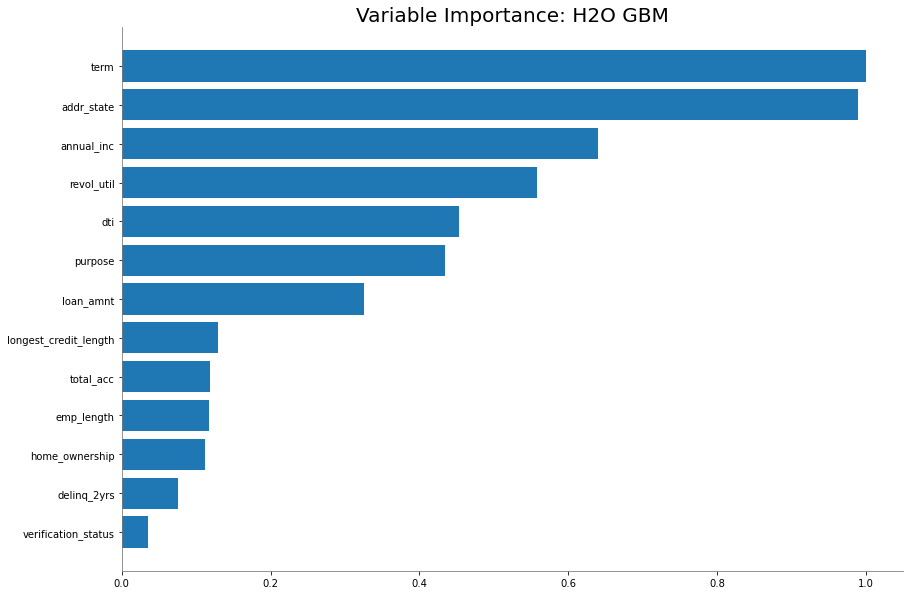

In [18]:
aml.leader.varimp_plot(13)

上位に入るaddr_stateは50水準、purposeは14水準のカテゴリカル変数

In [19]:
print( loans['addr_state'].table().dim[0] )
print( loans['purpose'].table().dim[0] )

50
14


***

<a id='FE'></a>
### 3. Feature Engineeringとそれを利用したモデルの作成

練習として、以下5つのFeature Engineeringをそれぞれの変数に実施する
1. **代数変換(Algebraic Transformation)**
    - 年収(USD)(annual_inc)と与信枠数(total_acc)の比
<br><br>
2. **Target Encoding**
    - 居住数(addr_state)
    - ローン借り入れ理由(purpose)
<br><br>
3. **Combining Categories**
    - 住所形態(home_ownership)
<br><br>
4. **Indicator Functions**
    - 申し込まれたローン期間(月)(term)
    - 所得確認状況(verification_status)
    - 継続雇用期間(年)(emp_length) - 欠損を示すIndicator
<br><br>
5. **Separating Typical from Extreme**
    - 申し込まれたローンの額(USD)(loan_amnt)
    - リボルビングクレジット利用率(%)(revol_util)
    - 過去2年における滞納回数(delinq_2yrs)
    - 年収(USD)(annual_inc)
    - 負債比率(%)(dti)
    - 与信枠数(total_acc)
    - 最長の与信枠(年)(longest_credit_length)

#### 1. 代数変換(Algebraic Transformation)

与信枠数に対する年収を算出`annual_inc/total_acc`  
分布の歪みを整えるため、対数変換も実施

Probs,annual_incQuantiles
0.01,794.19
0.1,1400
0.25,1928.57
0.333,2189.45
0.5,2772.73
0.667,3529.41
0.75,4090.91
0.9,6000
0.99,13562.2


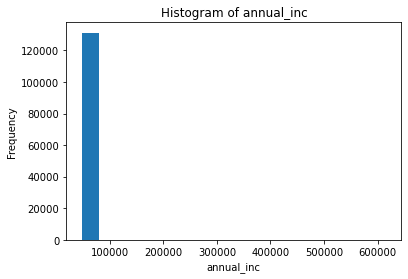

In [20]:
#> 対数変換しない場合
print( (train['annual_inc']/train['total_acc']).quantile() )
(train['annual_inc']/train['total_acc']).hist()

Probs,log(annual_inc)Quantiles
0.01,6.67732
0.1,7.24423
0.25,7.56453
0.333,7.69141
0.5,7.92759
0.667,8.16889
0.75,8.31652
0.9,8.69951
0.99,9.51504


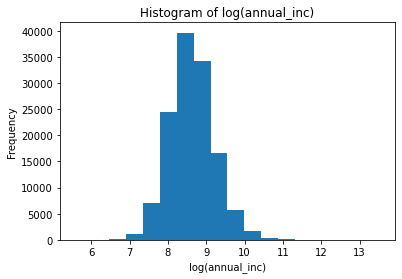

In [21]:
#> 対数変換した場合
print( (train['annual_inc'].log()-train['total_acc'].log()).quantile() )
(train['annual_inc'].log()-train['total_acc'].log()).hist()

In [22]:
transformed = predictors.copy()    # Feature Engineeringを加えた変数のリストtransformedとする

train['log_inc_per_acct'] = train['annual_inc'].log()-train['total_acc'].log()

transformed.append('log_inc_per_acct')
len(transformed)

14

#### 2. Target Encoding

多水準カテゴリカル変数(High-cardinality Categorical Variable)に対し、Cross Varidationを用いた平均値によるTarget Encodingを実施（One-hot Encodingを多水準カテゴリカル変数に実施した場合、オーバーフィッティングが発生する可能性が高いため）  

[参考リソース](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md)

In [23]:
cv_nfolds = 5
cv_seed = 12345
train["cv_fold"] = train.kfold_column(n_folds=cv_nfolds, seed=cv_seed)

train["cv_fold"].table()

cv_fold,Count
0,26201
1,26268
2,26424
3,26020
4,26335


In [24]:
import numpy as np
import pandas as pd

def logit(p):
    return np.log(p) - np.log(1 - p)

def mean_target(data, x, y="bad_loan"):
    """
    xの水準別にyの平均値を算出
    """
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na="ignore").mean(na="ignore")
    return stats.get_frame().as_data_frame()

def mean_target_encoding(data, x, y="bad_loan", fold_column="cv_fold", prior_mean=0.183, prior_count=1):
    """
    Creates target encoding for binary target
    クロスバリデーションTarget Encoding（x*fold_column別にyの集計地を算出）
    
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])   # x*fold_columnでgroup by
    grouped_data.sum(na="ignore").count(na="ignore")   # group by別で、yの合計値を計算（下のsum_yとなる値）
    df = grouped_data.get_frame().as_data_frame()
    #print(df)
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):     # k fold別の処理
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]    # out of foldデータ（x*fold_columnに集約済みデータからkデータを除いたもの）
        #print(oof.shape)
        stats = oof.groupby([x]).sum()    # さらにsum_yの合計を取る
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)   # nrowはgroup by時に作成される
        stats[te_x] = logit(p)
        #stats[te_x] = p
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))
    #return pd.concat(df_list)

- ローン借り入れ理由(purpose)に対しするTarget Encoding

In [25]:
#> ローン借り入れ理由(purpose)に対しての水準数の集計
tbl = train["purpose"].table().as_data_frame()    # 水準数の集計とPandas DFへの変換
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by="Count", ascending=0)
tbl = tbl.reset_index(drop=True)
tbl

,purpose,Count,Percent
0,debt_consolidation,74560,56.81
1,credit_card,24713,18.83
2,other,8416,6.41
3,home_improvement,7940,6.05
4,major_purchase,3750,2.86
5,small_business,3069,2.34
6,car,2280,1.74
7,medical,1626,1.24
8,wedding,1409,1.07
9,moving,1165,0.89


In [26]:
#> purposeの水準別のbad_loanの平均値の確認
df = mean_target(data=train, x="purpose", y="bad_loan")
print(df.shape)
df

(14, 3)


,purpose,nrow,mean_bad_loan
0,car,2280,0.126316
1,credit_card,24713,0.157528
2,debt_consolidation,74560,0.188560
3,educational,312,0.211538
4,home_improvement,7940,0.153149
5,house,990,0.182828
6,major_purchase,3750,0.136000
7,medical,1626,0.197417
8,moving,1165,0.205150
9,other,8416,0.213641


In [27]:
#> purposeに対してクロスバリデーションTarget Encodingの実施
te_purpose = mean_target_encoding(data=train, x="purpose", y="bad_loan", fold_column="cv_fold")
print( te_purpose.shape )
te_purpose

Parse progress: |█████████████████████████████████████████████████████████| 100%
(70, 3)


purpose,cv_fold,te_purpose
car,0,-1.89012
credit_card,0,-1.67871
debt_consolidation,0,-1.45385
educational,0,-1.26173
home_improvement,0,-1.71976
house,0,-1.46434
major_purchase,0,-1.84313
medical,0,-1.37289
moving,0,-1.3466
other,0,-1.2831


In [28]:
#> Target Encode済みのカラムをtrainへマージ
print( train.shape )
train = train.merge(te_purpose, all_x=True)
print( train.shape )

(131248, 17)
(131248, 18)


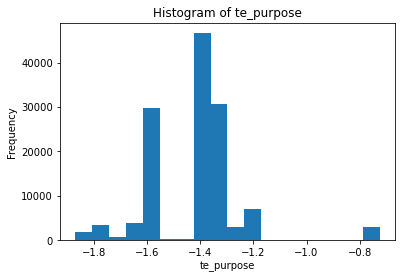

In [29]:
train["te_purpose"].hist()

In [30]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_purposeを追加し、purposeを削除
transformed.remove("purpose")
transformed.append("te_purpose")
len(transformed)

14

In [31]:
#transformed

- 居住数(addr_state)に対しするTarget Encoding

In [32]:
#> 水準数の集計
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
tbl

,addr_state,Count,Percent
0,CA,22897,17.45
1,NY,11514,8.77
2,TX,9612,7.32
3,FL,9061,6.90
4,NJ,5154,3.93
5,IL,4855,3.70
6,PA,4401,3.35
7,VA,4259,3.25
8,GA,4159,3.17
9,OH,3932,3.00


In [33]:
#> 準別のbad_loanの平均値の確認
df = mean_target(train, "addr_state")
print(df.shape)
df

(50, 3)


,addr_state,nrow,mean_bad_loan
0,AK,334,0.161677
1,AL,1580,0.215190
2,AR,887,0.191657
3,AZ,3152,0.174810
4,CA,22897,0.177840
5,CO,2837,0.141699
6,CT,2051,0.173574
7,DC,460,0.108696
8,DE,344,0.162791
9,FL,9061,0.211566


In [34]:
#> addr_stateに対してクロスバリデーションTarget Encodingの実施
te_addr_state = mean_target_encoding(data=train, x="addr_state", fold_column="cv_fold", prior_mean=0.183, prior_count=30)
print( te_addr_state.shape )
te_addr_state

Parse progress: |█████████████████████████████████████████████████████████| 100%
(250, 3)


addr_state,cv_fold,te_addr_state
AK,0,-1.55264
AL,0,-1.3366
AR,0,-1.36581
AZ,0,-1.5574
CA,0,-1.51659
CO,0,-1.77826
CT,0,-1.6278
DC,0,-2.16897
DE,0,-1.55591
FL,0,-1.31814


In [35]:
#> Target Encode済みのカラムをtrainへマージ
print( train.shape )
train = train.merge(te_addr_state, all_x=True)
print( train.shape )

(131248, 18)
(131248, 19)


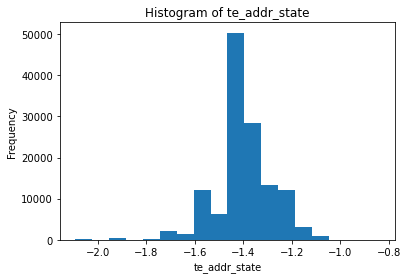

In [36]:
train["te_addr_state"].hist()

In [37]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_addr_stateを追加し、addr_stateを削除
transformed.remove("addr_state")
transformed.append("te_addr_state")
len(transformed)

14

**現時点でのFeature Engineeringを用いて、精度向上や変化かがあるか確認してみる**

In [38]:
check = H2OAutoML(max_models = 4,
                  max_runtime_secs_per_model = 60,
                  include_algos = ['GBM'],
                  seed = 12345)

%time check.train(x = transformed, y = response, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 4.67 s, sys: 209 ms, total: 4.88 s
Wall time: 2min 21s


In [39]:
check.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201015_085000,0.681168,0.443484,0.321635,0.367962,0.373367,0.139403
GBM_2_AutoML_20201015_085000,0.680596,0.443691,0.320188,0.368993,0.373486,0.139492
GBM_3_AutoML_20201015_085000,0.678399,0.444515,0.317744,0.370969,0.373886,0.139791
GBM_4_AutoML_20201015_085000,0.672408,0.447421,0.309256,0.375203,0.375238,0.140803


In [40]:
#> leaderboardの一番上のモデル
check.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201015_085000


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,51.0,51.0,41344.0,6.0,6.0,6.0,47.0,64.0,60.215687




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13488654616366264
RMSE: 0.3672690378505417
LogLoss: 0.43089346674157736
Mean Per-Class Error: 0.34685931803079106
AUC: 0.7121095844116323
AUCPR: 0.38130082099413726
Gini: 0.4242191688232646

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20760395546812344: 


,,0,1,Error,Rate
0,0,79615.0,27693.0,0.2581,(27693.0/107308.0)
1,1,10632.0,13308.0,0.4441,(10632.0/23940.0)
2,Total,90247.0,41001.0,0.292,(38325.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.207604,0.409849,218.0
1,max f2,0.127132,0.563113,308.0
2,max f0point5,0.313557,0.397793,133.0
3,max accuracy,0.424266,0.823814,73.0
4,max precision,0.868953,1.000000,0.0
5,max recall,0.039186,1.000000,397.0
6,max specificity,0.868953,1.000000,0.0
7,max absolute_mcc,0.251275,0.252055,178.0
8,max min_per_class_accuracy,0.182302,0.652214,244.0
9,max mean_per_class_accuracy,0.180186,0.653141,246.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.492072,3.937454,3.937454,0.718203,0.551197,0.718203,0.551197,0.039390,0.039390,293.745420,293.745420,0.035942
1,2,0.020000,0.447139,3.167407,3.552577,0.577744,0.467966,0.648000,0.509597,0.031662,0.071053,216.740734,255.257744,0.062442
2,3,0.030004,0.418342,2.764151,3.289702,0.504189,0.431920,0.600051,0.483698,0.027652,0.098705,176.415130,228.970199,0.084028
3,4,0.040001,0.395960,2.444503,3.078483,0.445884,0.406543,0.561524,0.464417,0.024436,0.123141,144.450303,207.848275,0.101689
4,5,0.050005,0.377833,2.388360,2.940416,0.435644,0.386654,0.536340,0.448860,0.023893,0.147034,138.836034,194.041620,0.118677
5,6,0.100002,0.317817,2.109569,2.525024,0.384791,0.345077,0.460571,0.396972,0.105472,0.252506,110.956885,152.502418,0.186528
6,7,0.150006,0.278792,1.679880,2.243295,0.306415,0.297117,0.409183,0.363686,0.084002,0.336508,67.987983,124.329509,0.228110
7,8,0.200003,0.250920,1.538105,2.067011,0.280555,0.264164,0.377029,0.338807,0.076901,0.413409,53.810545,106.701111,0.261015
8,9,0.300005,0.211136,1.281518,1.805180,0.233752,0.230011,0.329270,0.302542,0.128154,0.541562,28.151765,80.517996,0.295448
9,10,0.399998,0.182193,1.093634,1.627304,0.199482,0.196061,0.296825,0.275923,0.109357,0.650919,9.363391,62.730361,0.306900




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1394032616730032
RMSE: 0.3733674619901997
LogLoss: 0.44348409288013735
Mean Per-Class Error: 0.36796176211082243
AUC: 0.6811681380673636
AUCPR: 0.3216352905832189
Gini: 0.3623362761347273

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18052267261216992: 


,,0,1,Error,Rate
0,0,68392.0,38916.0,0.3627,(38916.0/107308.0)
1,1,8936.0,15004.0,0.3733,(8936.0/23940.0)
2,Total,77328.0,53920.0,0.3646,(47852.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.180523,0.385410,246.0
1,max f2,0.119076,0.551402,316.0
2,max f0point5,0.277907,0.348584,158.0
3,max accuracy,0.524739,0.818199,35.0
4,max precision,0.862160,1.000000,0.0
5,max recall,0.039849,1.000000,396.0
6,max specificity,0.862160,1.000000,0.0
7,max absolute_mcc,0.211588,0.208865,217.0
8,max min_per_class_accuracy,0.178708,0.630065,248.0
9,max mean_per_class_accuracy,0.180523,0.632038,246.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.488563,2.843485,2.843485,0.518660,0.544702,0.518660,0.544702,0.028446,0.028446,184.348495,184.348495,0.022557
1,2,0.020000,0.445065,2.523897,2.683752,0.460366,0.464998,0.489524,0.504865,0.025230,0.053676,152.389714,168.375192,0.041188
2,3,0.030004,0.416108,2.405062,2.590832,0.438690,0.429371,0.472575,0.479694,0.024060,0.077736,140.506216,159.083174,0.058381
3,4,0.040001,0.395523,2.060068,2.458191,0.375762,0.405406,0.448381,0.461129,0.020593,0.098329,106.006836,145.819145,0.071341
4,5,0.050005,0.377916,2.317378,2.430020,0.422696,0.386248,0.443242,0.446149,0.023183,0.121512,131.737760,143.002010,0.087461
5,6,0.100002,0.316795,1.888169,2.159115,0.344407,0.344772,0.393829,0.395464,0.094403,0.215915,88.816856,115.911497,0.141773
6,7,0.150006,0.278235,1.658161,1.992122,0.302453,0.296528,0.363369,0.362484,0.082916,0.298830,65.816084,99.212178,0.182026
7,8,0.200003,0.250890,1.470432,1.861709,0.268211,0.263915,0.339581,0.337843,0.073517,0.372348,47.043215,86.170931,0.210794
8,9,0.300005,0.211461,1.303656,1.675692,0.237790,0.229966,0.305651,0.301884,0.130368,0.502715,30.365599,67.569154,0.247934
9,10,0.399998,0.182784,1.127888,1.538749,0.205730,0.196585,0.280672,0.275561,0.112782,0.615497,12.788830,53.874855,0.263576




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.6398649,0.013740261,0.6331428,0.63961905,0.6543619,0.6514534,0.62074745
1,auc,0.6812033,0.0040922603,0.67858166,0.6866174,0.6843163,0.6768954,0.6796057
2,aucpr,0.32185474,0.0018727183,0.32041943,0.32439688,0.3211631,0.32321897,0.32007533
3,err,0.36013508,0.013740261,0.36685714,0.36038095,0.3456381,0.34854662,0.37925255
4,err_count,9453.4,360.62347,9630.0,9460.0,9073.0,9149.0,9955.0
5,f0point5,0.31499654,0.0034588818,0.31478998,0.31662047,0.3190264,0.31492803,0.3096178
6,f1,0.38635927,0.0034361149,0.38779402,0.38936225,0.3884058,0.38077834,0.3854559
7,f2,0.49973467,0.01141779,0.5048833,0.50549746,0.4963476,0.48144725,0.51049775
8,lift_top_group,2.8100142,0.039979886,2.7512362,2.7980177,2.8070872,2.8409379,2.8527923
9,logloss,0.44348413,0.002843595,0.446275,0.44156453,0.4395652,0.44566694,0.44434893



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-15 08:50:29,29.193 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-15 08:50:29,29.545 sec,5.0,0.379135,0.457904,0.675906,0.328755,3.189065,0.340904
2,,2020-10-15 08:50:30,29.976 sec,10.0,0.375607,0.449731,0.687545,0.342147,3.361241,0.323586
3,,2020-10-15 08:50:30,30.381 sec,15.0,0.373224,0.444339,0.691893,0.348829,3.444750,0.328013
4,,2020-10-15 08:50:31,30.777 sec,20.0,0.371685,0.440854,0.695014,0.354479,3.557488,0.329201
5,,2020-10-15 08:50:31,31.166 sec,25.0,0.370621,0.438386,0.699088,0.359503,3.620120,0.332736
6,,2020-10-15 08:50:31,31.569 sec,30.0,0.369749,0.436393,0.702123,0.364069,3.636821,0.327578
7,,2020-10-15 08:50:32,31.969 sec,35.0,0.368967,0.434609,0.705560,0.369291,3.703629,0.324432
8,,2020-10-15 08:50:32,32.360 sec,40.0,0.368324,0.433236,0.707822,0.374009,3.799664,0.289422
9,,2020-10-15 08:50:33,32.763 sec,45.0,0.367782,0.432005,0.710126,0.377548,3.870647,0.289559



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1824.283325,1.000000,0.212127
1,annual_inc,1206.010864,0.661087,0.140235
2,revol_util,1146.101440,0.628248,0.133268
3,dti,951.906555,0.521798,0.110687
4,te_purpose,691.648926,0.379135,0.080425
5,loan_amnt,666.100464,0.365130,0.077454
6,te_addr_state,391.561066,0.214638,0.045531
7,longest_credit_length,363.639435,0.199333,0.042284
8,total_acc,320.121674,0.175478,0.037224
9,emp_length,284.338654,0.155863,0.033063


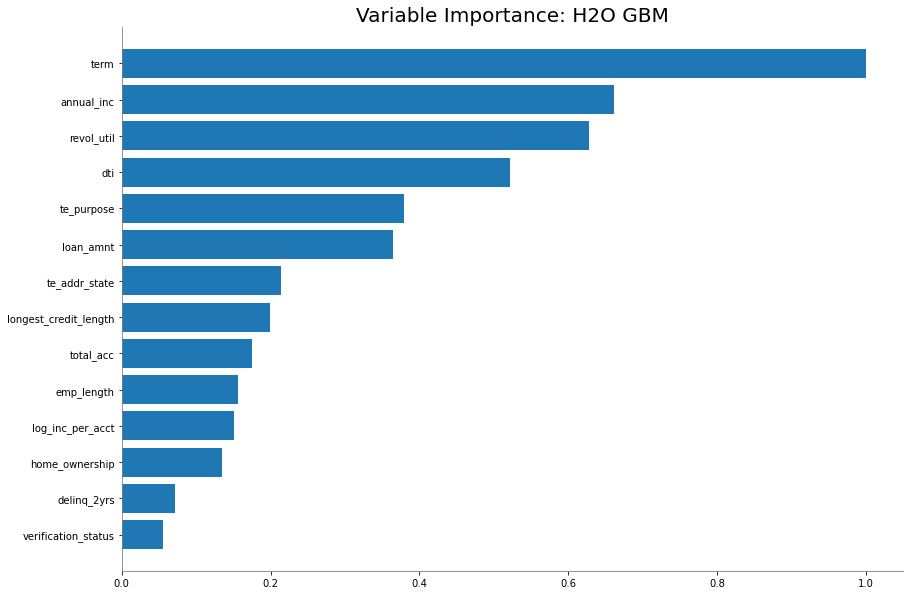

In [41]:
#> 変数重要度
check.leader.varimp_plot(14)

- log_inc_per_acctは11番目
- Target Encodingにより、addr_stateの重要度が低下した（Base Modelではオーバーフィッティング気味）

In [42]:
#> テストデータに対する結果の取得
#perf2 = check.leader.model_performance(test_data=test)    #>> testデータへのfeature engineering

In [43]:
print("--- AUC of Base Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))
print("--- AUC of 中間 Model ---")
#print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(check.leader.auc(train=True),
#                                                                  check.leader.auc(xval=True), 
#                                                                  perf2.auc()))

--- AUC of Base Model ---
AUC: train = 0.7258, X-val = 0.6812, test = 0.6835
--- AUC of 中間 Model ---
AUC: train = 0.7121, X-val = 0.6812, test = 0.6753


精度向上が見込めなかったのは、H2OGradientBoostingEstimatorにおいて多水準カテゴリカル変数(High-cardinality Categorical Variable)の自動処理が組み込まれているためと推測できる  
H2OGradientBoostingEstimatorの[categorical_encoding引数に関して](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/categorical_encoding.html)

#### 3. Combining Categories

住所形態(home_ownership)は6水準のカテゴリカル変数だが、バランスの悪い構成となっている  
数の少ないANY,NONE,OTHERとRENTと結合して、OTHERカテゴリとする

In [44]:
#> home_ownership別での、bad_loanの平均割合
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,63757,0.163496
2,NONE,27,0.259259
3,OTHER,116,0.250000
4,OWN,10903,0.186004
5,RENT,56444,0.202891


In [45]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()
train[["home_ownership", "home_ownership_3cat"]].table()

transformed.remove("home_ownership")
transformed.append("home_ownership_3cat")
print( len(transformed) )

mean_target(train, "home_ownership_3cat")

14


,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,63757,0.163496
1,OTHER,56588,0.203011
2,OWN,10903,0.186004


#### 4. Indicator Functions

- ローン期間(term)を5年を示す場合に1、3年を0に変換

In [46]:
train["term"].table()

term,Count
36 months,104026
60 months,27222


In [47]:
#> 60 months->1, 36 months -> 0 へ変換
train["term_60months"] = (train["term"] == "60 months")
train["term_60months"].table()

term_60months,Count
0,104026
1,27222


In [48]:
#> 変数名の置き換え
transformed.remove("term")
transformed.append("term_60months")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months']

- 所得確認状況(verification_status)をverifiedの場合1に、not varifiedの場合に0に変換

In [49]:
train["verification_status"].table()

verification_status,Count
not verified,47286
verified,83962


In [50]:
train["verified"] = (train["verification_status"] == "verified")
train["verified"].table()

verified,Count
0,47286
1,83962


In [51]:
transformed.remove("verification_status")
transformed.append("verified")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified']

- 継続雇用期間(年)(emp_length)が欠損を示す新しい変数（欠損だと1）を作成

In [52]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6808450125614245
maxs,10.0
sigma,3.608577939766145
zeros,11391
missing,4670
0,nan
1,10.0
2,1.0


In [53]:
#> 欠損の割合
train["emp_length"].isna().sum() / train.nrows

0.03558149457515543

In [54]:
#> emp_lengthが欠損(nan)だと1となる変数(emp_length_missing)を作成
train["emp_length_missing"] = (train["emp_length"] == None)
train["emp_length_missing"].table()

emp_length_missing,Count
0,126578
1,4670


In [55]:
#> 変数名の追加
transformed.append("emp_length_missing")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing']

In [56]:
#> emp_lengthの水準別にbad_loanの割合を確認してみる
df = mean_target(train, "emp_length")
df.drop(df.index[:1], inplace=True)   # remove NaN
df

,emp_length,nrow,mean_bad_loan
1,0.0,11391,0.183127
2,1.0,9056,0.178666
3,2.0,12712,0.171413
4,3.0,10930,0.178957
5,4.0,8825,0.171671
6,5.0,9910,0.180424
7,6.0,8035,0.186808
8,7.0,7259,0.190384
9,8.0,5901,0.182342
10,9.0,4871,0.185178


In [57]:
#> emp_length_missingの水準別にbad_loanの割合を確認してみる
mean_target(train, "emp_length_missing")

,emp_length_missing,nrow,mean_bad_loan
0,0,126578,0.179494
1,1,4670,0.261242


欠損か否かで大きくbad_loanの割合が異なっている

#### 5. Separating Typical from Extreme

極端な値を含む変数から、それを考慮した新しい変数を作成することにより精度向上につながることがある  
ここでは、「典型」と「外れ」を示す変数を作成して行く

- ローン額(loan_amnt)に対し、変数変換を実施

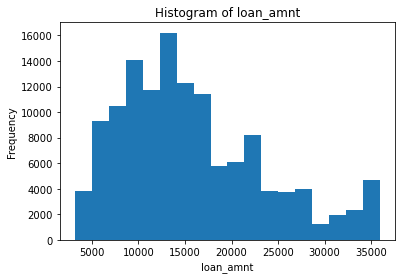

In [58]:
train["loan_amnt"].hist()

In [59]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [60]:
#> 0から35000の間を等間隔に分け、8つの閾値を作成（7つの区間）
breaks = np.linspace(0, 35000, 8).tolist()
breaks

[0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0]

In [61]:
#> loan_amountを7つの区間に分けたカテゴリ変数（loan_amnt_cat）を作成
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)
train[["loan_amnt_cat","loan_amnt"]]

loan_amnt_cat,loan_amnt
"(0.0,5000.0]",3500
"(5000.0,10000.0]",7500
"(10000.0,15000.0]",15000
"(15000.0,20000.0]",20000
"(5000.0,10000.0]",6950
"(30000.0,35000.0]",35000
"(5000.0,10000.0]",10000
"(10000.0,15000.0]",10400
"(15000.0,20000.0]",20000
"(10000.0,15000.0]",13000


In [62]:
mean_target(train, "loan_amnt_cat")

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",20634,0.164050
1,"(5000.0,10000.0]",40364,0.162397
2,"(10000.0,15000.0]",28359,0.172785
3,"(15000.0,20000.0]",19727,0.208800
4,"(20000.0,25000.0]",11572,0.212323
5,"(25000.0,30000.0]",5565,0.240611
6,"(30000.0,35000.0]",5027,0.235727


loan_amntが5000から30000までbad_loanが増えていっており、5000より下と、30000より上はフラットになっている

In [63]:
#> 5000より下と、30000より上のloan_amntはそれぞれ5000と30000に置き換える新しい変数（loan_amnt_core）を作成
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)
train[["loan_amnt","loan_amnt_core"]]

loan_amnt,loan_amnt_core
3500,5000
7500,7500
15000,15000
20000,20000
6950,6950
35000,30000
10000,10000
10400,10400
20000,20000
13000,13000


In [64]:
#> 置き換えを示す情報を持つ変数（loan_amnt_diff）を作成しておく
train["loan_amnt_diff"] = train["loan_amnt"] - train["loan_amnt_core"]
train[["loan_amnt","loan_amnt_core","loan_amnt_diff"]]

loan_amnt,loan_amnt_core,loan_amnt_diff
3500,5000,-1500
7500,7500,0
15000,15000,0
20000,20000,0
6950,6950,0
35000,30000,5000
10000,10000,0
10400,10400,0
20000,20000,0
13000,13000,0


In [65]:
#> 変数名の削除と追加
transformed.remove("loan_amnt")
transformed.append("loan_amnt_core")
transformed.append("loan_amnt_diff")
transformed

['emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff']

- リボルビングクレジット利用率(%)(revol_util)に対する変数変換の実施

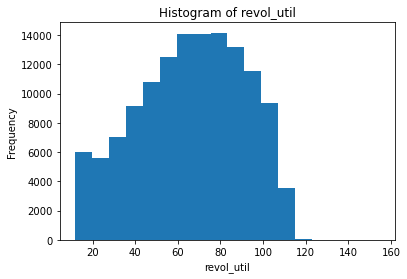

In [66]:
train["revol_util"].hist()

In [68]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.3
0.95,92.5
1,150.7


In [70]:
#> 欠損数
train["revol_util"].isna().sum()

145.0

In [71]:
#> カテゴリ化してbad_loanの傾向を確認
breaks = np.linspace(0, 120, 25).tolist()    # 0から120の間を等間隔に分け、25つの閾値を作成（24つの区間）
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")
df.drop(df.index[:1], inplace=True)   # remove NaN

df

,revol_util_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",3005,0.102496
2,"(5.0,10.0]",3220,0.096273
3,"(10.0,15.0]",3485,0.105022
4,"(15.0,20.0]",4185,0.115412
5,"(20.0,25.0]",4848,0.127475
6,"(25.0,30.0]",5675,0.142907
7,"(30.0,35.0]",6383,0.153063
8,"(35.0,40.0]",7090,0.152045
9,"(40.0,45.0]",7780,0.157584
10,"(45.0,50.0]",8555,0.177089


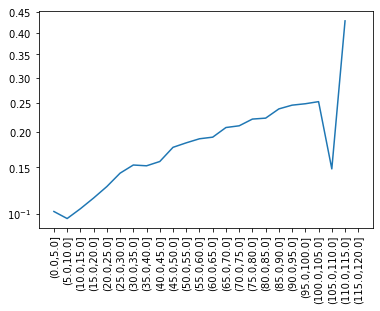

In [82]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["revol_util_cat"], df["mean_bad_loan"])

In [97]:
#> revol_utilが0のbad_loanの割合
train[["revol_util","bad_loan"]][train["revol_util"]==0].group_by("revol_util").count().mean().get_frame()

revol_util,nrow,mean_bad_loan
0,1244,0.159968


以下3つの特徴を変数化する  
(a)revol_utilが0%だとややbad_loanが高くなる -> 指示変数の作成  
(b)その後、100%付近までbad_loanが上昇していく -> 「典型」  
(c)100%を超えるとイレギュラーな動き -> 「外れ」

In [98]:
train["revol_util_0"] = (train["revol_util"] == 0)   # (a)
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)   # (b)
train["revol_util_diff"] = train["revol_util"] - train["revol_util_core"]   # (c)

In [99]:
#> 変数名の削除と追加
transformed.remove("revol_util")
transformed.append("revol_util_0")
transformed.append("revol_util_core")
transformed.append("revol_util_diff")
transformed

['emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff',
 'revol_util_0',
 'revol_util_core',
 'revol_util_diff']

以下の変数に対し同様に分析を行い、新しい変数（「典型」と「外れ」を示す）を作成する  

過去2年における滞納回数(delinq_2yrs)
- delinq_2yrs_core = min(delinq_2yrs, 3)
- delinq_2yrs_diff = delinq_2yrs − delinq_2yrs_core

年収(USD)(annual_inc)
- annual_inc_core = max(10000, min(annual_inc, 105000))
- annual_inc_diff = annual_inc - annual_inc_core

負債比率(%)(dti)
- dti_core = max(5, min(dti, 30))
- dti_diff = dti − dti_core

与信枠数(total_acc)
- total_acc_core = min(total_acc, 50)
- total_acc_diff = total_acc − total_acc_core

最長の与信枠(年)(longest_credit_length)
- longest_credit_length_core = max(3, min(longest_credit_length, 20))
- longest_credit_length_diff = longest_credit_length − longest_credit_length_core

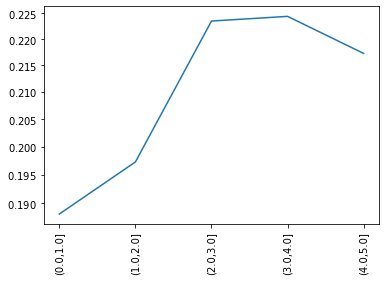

In [101]:
#> delinq_2yrs
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

df = mean_target(train, "delinq_2yrs_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["delinq_2yrs_cat"], df["mean_bad_loan"])

transformed.remove("delinq_2yrs")
transformed.append("delinq_2yrs_core")
transformed.append("delinq_2yrs_diff")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)
train["delinq_2yrs_diff"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

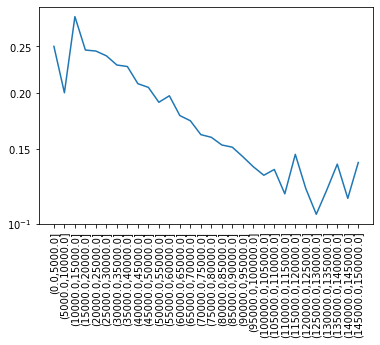

In [102]:
#> annual_inc
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["annual_inc_cat"], df["mean_bad_loan"])

transformed.remove("annual_inc")
transformed.append("annual_inc_core")
transformed.append("annual_inc_diff")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_diff"] = train["annual_inc"] - train["annual_inc_core"]

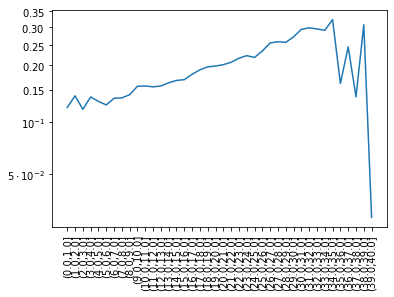

In [103]:
#> dti
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["dti_cat"], df["mean_bad_loan"])

transformed.remove("dti")
transformed.append("dti_core")
transformed.append("dti_diff")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_diff"] = train["dti"] - train["dti_core"]

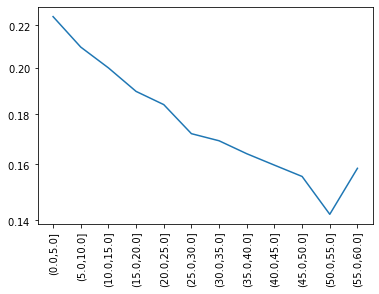

In [104]:
#> total_acc
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["total_acc_cat"], df["mean_bad_loan"])

(train["total_acc"] == None).table()

transformed.remove("total_acc")
transformed.append("total_acc_core")
transformed.append("total_acc_diff")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_diff"] = train["total_acc"] - train["total_acc_core"]

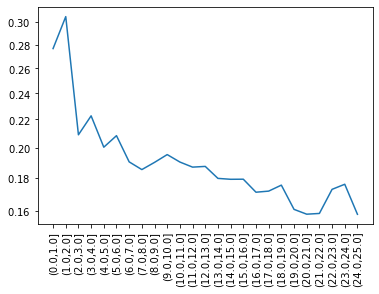

In [105]:
#> longest_credit_length
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["longest_credit_length_cat"], df["mean_bad_loan"])

transformed.remove("longest_credit_length")
transformed.append("longest_credit_length_core")
transformed.append("longest_credit_length_diff")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)
train["longest_credit_length_diff"] = train["longest_credit_length"] - train["longest_credit_length_core"]

In [107]:
#> 最終的なモデルに利用する変数リスト
print(len(transformed))
transformed

23


['emp_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff',
 'revol_util_0',
 'revol_util_core',
 'revol_util_diff',
 'delinq_2yrs_core',
 'delinq_2yrs_diff',
 'annual_inc_core',
 'annual_inc_diff',
 'dti_core',
 'dti_diff',
 'total_acc_core',
 'total_acc_diff',
 'longest_credit_length_core',
 'longest_credit_length_diff']

**すべてのFeature Engineering結果を用いて、最終的なモデルを作成してみる**

In [108]:
final = H2OAutoML(max_models = 4,
                  max_runtime_secs_per_model = 60,
                  include_algos = ['GBM'],
                  seed = 12345)

%time final.train(x = transformed, y = response, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 7.38 s, sys: 218 ms, total: 7.59 s
Wall time: 3min 4s


In [110]:
final.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201015_094518,0.681851,0.443249,0.322122,0.367647,0.373262,0.139324
GBM_2_AutoML_20201015_094518,0.680042,0.443956,0.319058,0.371669,0.373642,0.139608
GBM_3_AutoML_20201015_094518,0.678842,0.444552,0.316942,0.372347,0.373917,0.139814
GBM_4_AutoML_20201015_094518,0.672598,0.447635,0.307245,0.376017,0.375416,0.140937


In [111]:
#> leaderboardの一番上のモデル
final.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201015_094518


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,53.0,53.0,43702.0,6.0,6.0,6.0,43.0,64.0,61.16981




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13441302845780784
RMSE: 0.36662382418196426
LogLoss: 0.42967842948427054
Mean Per-Class Error: 0.3456228231019143
AUC: 0.7143246451185307
AUCPR: 0.3871919349529267
Gini: 0.42864929023706133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2124710534194587: 


,,0,1,Error,Rate
0,0,81480.0,25828.0,0.2407,(25828.0/107308.0)
1,1,10996.0,12944.0,0.4593,(10996.0/23940.0)
2,Total,92476.0,38772.0,0.2806,(36824.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.212471,0.412808,217.0
1,max f2,0.128081,0.563539,308.0
2,max f0point5,0.301307,0.402531,143.0
3,max accuracy,0.410864,0.824165,80.0
4,max precision,0.812947,1.000000,0.0
5,max recall,0.039378,1.000000,396.0
6,max specificity,0.812947,1.000000,0.0
7,max absolute_mcc,0.240347,0.256356,191.0
8,max min_per_class_accuracy,0.182155,0.653903,249.0
9,max mean_per_class_accuracy,0.183143,0.654377,248.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.499617,3.987560,3.987560,0.727342,0.558125,0.727342,0.558125,0.039891,0.039891,298.755966,298.755966,0.036555
1,2,0.020000,0.454708,3.167407,3.577640,0.577744,0.475226,0.652571,0.516692,0.031662,0.071554,216.740734,257.763972,0.063055
2,3,0.030004,0.426101,2.797555,3.317545,0.510282,0.439550,0.605130,0.490971,0.027987,0.099541,179.755494,231.754543,0.085050
3,4,0.040001,0.403265,2.686864,3.159935,0.490091,0.414272,0.576381,0.471804,0.026859,0.126399,168.686401,215.993514,0.105674
4,5,0.050005,0.383980,2.438466,3.015597,0.444783,0.393382,0.550053,0.456115,0.024394,0.150794,143.846580,201.559730,0.123275
5,6,0.100002,0.318034,2.082834,2.549251,0.379915,0.347657,0.464990,0.401890,0.104135,0.254929,108.283372,154.925105,0.189491
6,7,0.150006,0.277777,1.728330,2.275597,0.315252,0.296652,0.415075,0.366809,0.086424,0.341353,72.832987,127.559675,0.234036
7,8,0.200003,0.249319,1.503851,2.082675,0.274307,0.262793,0.379886,0.340807,0.075188,0.416541,50.385106,108.267503,0.264847
8,9,0.300005,0.210503,1.293213,1.819521,0.235886,0.228636,0.331886,0.303417,0.129323,0.545865,29.321338,81.952115,0.300711
9,10,0.399998,0.182277,1.066899,1.631376,0.194605,0.195748,0.297568,0.276501,0.106683,0.652548,6.689878,63.137631,0.308892




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13932440242352082
RMSE: 0.3732618416387092
LogLoss: 0.4432486159825008
Mean Per-Class Error: 0.36755776881475066
AUC: 0.681851475849201
AUCPR: 0.32212151494722363
Gini: 0.36370295169840205

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1832500216352049: 


,,0,1,Error,Rate
0,0,69849.0,37459.0,0.3491,(37459.0/107308.0)
1,1,9246.0,14694.0,0.3862,(9246.0/23940.0)
2,Total,79095.0,52153.0,0.3559,(46705.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.183250,0.386212,245.0
1,max f2,0.113041,0.551726,323.0
2,max f0point5,0.280735,0.350579,156.0
3,max accuracy,0.513849,0.818184,37.0
4,max precision,0.543036,0.550950,29.0
5,max recall,0.031900,1.000000,399.0
6,max specificity,0.853270,0.999981,0.0
7,max absolute_mcc,0.203468,0.209710,223.0
8,max min_per_class_accuracy,0.178620,0.631579,250.0
9,max mean_per_class_accuracy,0.181418,0.632442,247.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.493691,2.868538,2.868538,0.523229,0.550112,0.523229,0.550112,0.028697,0.028697,186.853768,186.853768,0.022863
1,2,0.020000,0.451373,2.469575,2.669132,0.450457,0.469936,0.486857,0.510039,0.024687,0.053383,146.957485,166.913226,0.040831
2,3,0.030004,0.421913,2.421764,2.586655,0.441736,0.435693,0.471813,0.485251,0.024227,0.077611,142.176398,158.665523,0.058227
3,4,0.040001,0.400394,2.243928,2.501006,0.409299,0.410829,0.456190,0.466653,0.022431,0.100042,124.392842,150.100617,0.073436
4,5,0.050005,0.381403,2.162886,2.433361,0.394516,0.390742,0.443852,0.451466,0.021637,0.121679,116.288576,143.336148,0.087665
5,6,0.100002,0.318179,1.902372,2.167887,0.346998,0.346889,0.395429,0.399181,0.095113,0.216792,90.237159,116.788676,0.142846
6,7,0.150006,0.278721,1.680715,2.005488,0.306567,0.297243,0.365807,0.365200,0.084043,0.300835,68.071517,100.548799,0.184479
7,8,0.200003,0.250918,1.449545,1.866513,0.264401,0.264264,0.340457,0.339968,0.072473,0.373308,44.954533,86.651291,0.211969
8,9,0.300005,0.211214,1.283606,1.672211,0.234133,0.229635,0.305016,0.303190,0.128363,0.501671,28.360617,67.221066,0.246657
9,10,0.399998,0.182254,1.145851,1.540628,0.209006,0.196094,0.281015,0.276418,0.114578,0.616249,14.585096,54.062826,0.264495




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.64836025,0.010212082,0.6384762,0.65870476,0.6590476,0.64703417,0.6385386
1,auc,0.6818689,0.004851659,0.6782667,0.68848836,0.68546283,0.6774252,0.67970127
2,aucpr,0.3224104,0.004618013,0.31929857,0.329922,0.3218759,0.32286945,0.31808603
3,err,0.35163972,0.010212082,0.3615238,0.34129524,0.34095237,0.35296583,0.3614614
4,err_count,9230.4,267.96884,9490.0,8959.0,8950.0,9265.0,9488.0
5,f0point5,0.31759757,0.0036807542,0.31562862,0.32219166,0.3209068,0.31406012,0.31520072
6,f1,0.38686505,0.003273998,0.3869509,0.38958916,0.38916188,0.3813848,0.38723844
7,f2,0.49485275,0.0065143364,0.49991655,0.49264225,0.49429592,0.4854501,0.50195897
8,lift_top_group,2.8813915,0.09713136,2.7926083,2.8815405,3.0392523,2.8824112,2.8111458
9,logloss,0.44324863,0.0032552227,0.4465581,0.4404217,0.43919194,0.4455823,0.4444892



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-15 09:45:57,38.354 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-15 09:45:57,38.836 sec,5.0,0.378859,0.457317,0.679547,0.332803,3.270260,0.335396
2,,2020-10-15 09:45:58,39.417 sec,10.0,0.375135,0.448751,0.687113,0.343390,3.408751,0.333453
3,,2020-10-15 09:45:58,39.937 sec,15.0,0.372884,0.443680,0.692109,0.350508,3.465628,0.320378
4,,2020-10-15 09:45:59,40.472 sec,20.0,0.371362,0.440255,0.695834,0.357098,3.536611,0.336645
5,,2020-10-15 09:45:59,40.999 sec,25.0,0.370249,0.437703,0.699954,0.362679,3.603418,0.332157
6,,2020-10-15 09:46:00,41.519 sec,30.0,0.369352,0.435675,0.703502,0.368232,3.695278,0.304111
7,,2020-10-15 09:46:00,42.038 sec,35.0,0.368576,0.433943,0.706322,0.373269,3.787138,0.300187
8,,2020-10-15 09:46:01,42.561 sec,40.0,0.367991,0.432648,0.708847,0.377362,3.833068,0.311525
9,,2020-10-15 09:46:01,43.076 sec,45.0,0.367473,0.431499,0.710941,0.380875,3.878998,0.292195



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term_60months,2032.815674,1.000000,0.225315
1,annual_inc_core,1273.303711,0.626374,0.141131
2,revol_util_core,1041.910400,0.512545,0.115484
3,dti_core,773.629089,0.380570,0.085748
4,te_purpose,702.242615,0.345453,0.077836
5,loan_amnt_core,651.952637,0.320714,0.072262
6,te_addr_state,370.293304,0.182158,0.041043
7,total_acc_core,325.623199,0.160183,0.036092
8,longest_credit_length_core,284.861908,0.140132,0.031574
9,log_inc_per_acct,255.032059,0.125458,0.028267



See the whole table with table.as_data_frame()


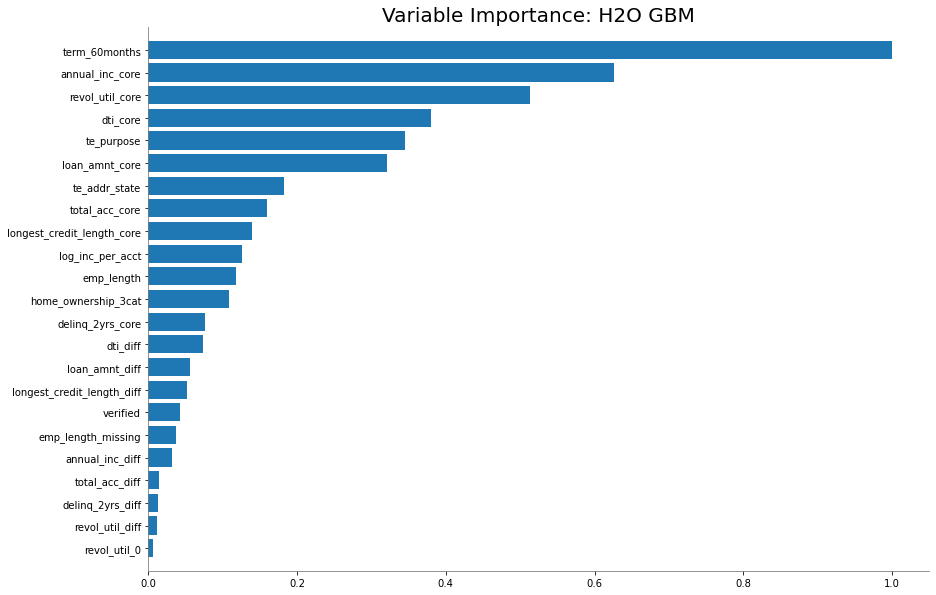

In [115]:
#> 変数重要度
final.leader.varimp_plot(23)

In [118]:
test

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5375,60 months,12.69,0,RENT,15000,other,TX,18.08,0,36.5,3,1,7,verified
6000,36 months,11.71,1,MORTGAGE,84000,medical,UT,18.44,2,37.73,14,0,8,verified
21000,36 months,12.42,10,RENT,105000,debt_consolidation,FL,13.22,0,90.3,38,1,28,verified
6000,36 months,11.71,1,RENT,76000,major_purchase,CA,2.4,0,29.7,7,1,10,not verified
12400,36 months,10.65,10,RENT,41000,credit_card,KY,11.8,0,57.2,12,0,6,not verified
11000,36 months,6.62,5,RENT,70000,debt_consolidation,CT,10.85,0,36.4,7,0,9,not verified
15000,36 months,9.91,8,MORTGAGE,80000,debt_consolidation,IL,9.12,0,63.7,28,1,19,not verified
10000,36 months,10.65,2,RENT,51400,credit_card,TX,19.14,0,59.1,24,0,11,not verified
17675,60 months,14.65,0,RENT,50000,debt_consolidation,WI,16.46,0,57.4,14,0,9,verified


In [116]:
#> テストデータに対する結果の取得
#perf3 = final.leader.model_performance(test_data=test)     #>>> testデータへのfeature engineering

In [117]:
print("--- AUC of Base Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))
print("--- AUC of 中間 Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(check.leader.auc(train=True),
                                                                  check.leader.auc(xval=True), 
                                                                  perf2.auc()))
print("--- AUC of 最終 Model ---")
#print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(final.leader.auc(train=True),
#                                                                  final.leader.auc(xval=True), 
#                                                                  perf3.auc()))

--- AUC of Base Model ---
AUC: train = 0.7258, X-val = 0.6812, test = 0.6835
--- AUC of 中間 Model ---
AUC: train = 0.7121, X-val = 0.6812, test = 0.6753
--- AUC of 最終 Model ---
AUC: train = 0.7143, X-val = 0.6819, test = 0.5088
